In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [ ]:
# Load Dataset
df = pd.read_csv("../Datasets/Unbalanced_Binary.csv")

In [5]:
# Splitting Data
X = df.drop(columns=["target"])  # Features
y = df["target"].values          # Target Variable

In [6]:
# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [9]:
# Create PyTorch Dataloader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
class OptimizedMLP(nn.Module):
    def __init__(self, input_size):
        super(OptimizedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1) 

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x)) 
        x = self.fc4(x)  
        return self.sigmoid(x) 

In [11]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimizedMLP(input_size=X_train.shape[1]).to(device)

In [12]:
# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5) # L2 Regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning Rate Scheduler

In [13]:
# Training Loop with Early Stopping
epochs = 100
best_val_loss = float("inf")
patience = 10  # Stop if validation loss doesn't improve for 5 consecutive epochs
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step()
    
    # Compute Validation Loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/100], Loss: 0.6207, Val Loss: 0.5292
Epoch [2/100], Loss: 0.4836, Val Loss: 0.3502
Epoch [3/100], Loss: 0.3876, Val Loss: 0.2870
Epoch [4/100], Loss: 0.3501, Val Loss: 0.2559
Epoch [5/100], Loss: 0.3159, Val Loss: 0.2300
Epoch [6/100], Loss: 0.2827, Val Loss: 0.2005
Epoch [7/100], Loss: 0.2599, Val Loss: 0.1809
Epoch [8/100], Loss: 0.2274, Val Loss: 0.1661
Epoch [9/100], Loss: 0.2090, Val Loss: 0.1556
Epoch [10/100], Loss: 0.1820, Val Loss: 0.1460
Epoch [11/100], Loss: 0.1697, Val Loss: 0.1452
Epoch [12/100], Loss: 0.1662, Val Loss: 0.1445
Epoch [13/100], Loss: 0.1589, Val Loss: 0.1439
Epoch [14/100], Loss: 0.1606, Val Loss: 0.1431
Epoch [15/100], Loss: 0.1654, Val Loss: 0.1424
Epoch [16/100], Loss: 0.1500, Val Loss: 0.1421
Epoch [17/100], Loss: 0.1630, Val Loss: 0.1414
Epoch [18/100], Loss: 0.1513, Val Loss: 0.1405
Epoch [19/100], Loss: 0.1530, Val Loss: 0.1396
Epoch [20/100], Loss: 0.1510, Val Loss: 0.1388
Epoch [21/100], Loss: 0.1426, Val Loss: 0.1387
Epoch [22/100], Loss: 

In [14]:
# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device)).cpu().numpy()
    y_pred_binary = (y_pred_probs >= 0.5).astype(int)

In [15]:
# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average="binary")
cm = confusion_matrix(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 0.9579, Recall: 1.0000, F1-Score: 0.9785


In [16]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 9  4]
 [ 0 91]]


In [17]:
# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Compute Sensitivity & Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 1.0000
Specificity: 0.6923


In [18]:
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.9615
              precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       0.96      1.00      0.98        91

    accuracy                           0.96       104
   macro avg       0.98      0.85      0.90       104
weighted avg       0.96      0.96      0.96       104



(array([0.5, 1.5]), [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

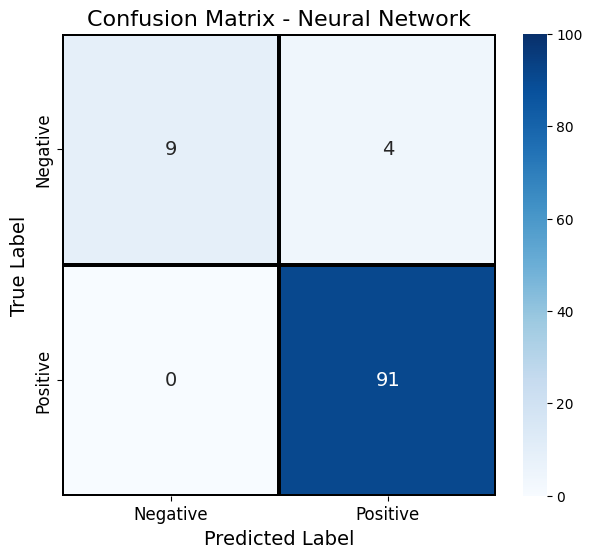

In [19]:
# Plot Confusion Matrix
plt.figure(figsize=(7,6))  # Increase figure size
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', 
                 linewidths=1.5, linecolor='black', 
                 annot_kws={"size": 14}, vmin=0, vmax=100,
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'])


plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix - Neural Network", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

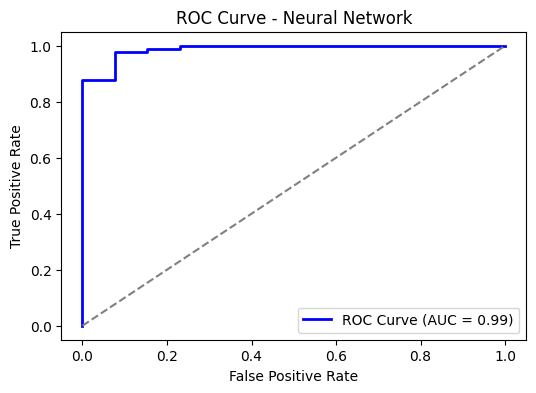

In [20]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend(loc="lower right")
plt.show()